torch.Size([1, 10, 512, 512])


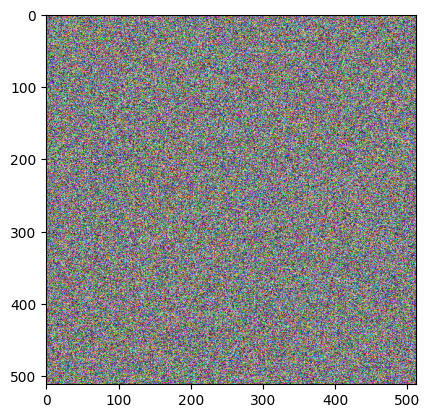

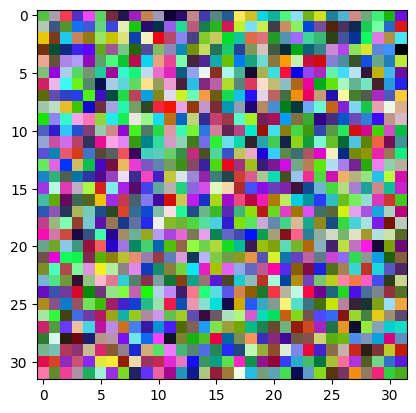

In [10]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Encoder - Double convolution
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.encoder(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Use DoubleConv for the convolutional part
        self.conv = DoubleConv(in_channels, out_channels)

        # MaxPooling for downsampling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # Apply convolution
        down = self.conv(x)

        # Apply MaxPooling
        pooled = self.pool(down)

        return down, pooled

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Transpose convolution for upsampling
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)

        # Use DoubleConv for the convolutional part
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        # Upsample
        x1 = self.up(x1)

        # Concatenate along the channel dimension
        x = torch.cat([x1, x2], 1)

        # Apply convolution
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UNet, self).__init__()

        # Implement downsampling
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        # Implement bottleneck
        self.bottleneck = DoubleConv(512, 1024)

        # Implement upsampling
        self.up_convolutional_1 = UpSample(1024, 512)
        self.up_convolutional_2 = UpSample(512, 256)
        self.up_convolutional_3 = UpSample(256, 128)
        self.up_convolutional_4 = UpSample(128, 64)

        # Return output 2D convolution
        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        # Downsampling
        down_1, pooled_1 = self.down_convolution_1(x)
        down_2, pooled_2 = self.down_convolution_2(pooled_1)
        down_3, pooled_3 = self.down_convolution_3(pooled_2)
        down_4, pooled_4 = self.down_convolution_4(pooled_3)

        # Bottleneck
        bottleneck = self.bottleneck(pooled_4)

        # Upsampling
        up_1 = self.up_convolutional_1(bottleneck, down_4)
        up_2 = self.up_convolutional_2(up_1, down_3)
        up_3 = self.up_convolutional_3(up_2, down_2)
        up_4 = self.up_convolutional_4(up_3, down_1)

        # Output
        output = self.out(up_4)
        return output


class MiniUNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(MiniUNet, self).__init__()

        # Implement downsampling
        self.down_convolution_1 = DownSample(in_channels, 64)

        # Implement bottleneck
        self.bottleneck = DoubleConv(64, 128)

        # Implement upsampling
        self.up_convolutional_1 = UpSample(128, 64)

        # Return output 2D convolution
        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        # Downsampling
        down_1, pooled_1 = self.down_convolution_1(x)


        # Bottleneck
        bottleneck = self.bottleneck(pooled_1)

        # Upsampling
        up_1 = self.up_convolutional_1(bottleneck, down_1)

        # Output
        output = self.out(up_1)
        return output

"""
# Debugging
if __name__ == "__main__":
    input_image = torch.rand((1, 3, 512, 512))
    input_image2 = torch.rand((1, 3, 32, 32))

    model = MiniUNet(3, 10)
    output = model(input_image)
    print(output.size())

import matplotlib.pyplot as plt

# Wandele den PyTorch Tensor in ein NumPy-Array um
image_np = input_image.numpy()
image_np2 = input_image2.numpy()

plt.imshow(image_np[0].transpose((1, 2, 0)))
plt.show()
plt.imshow(image_np2[0].transpose((1, 2, 0)))
plt.show()
"""

Implemented focal stack by ChatGPT as a dimension!

In [15]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Encoder - Double convolution
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.encoder(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Use DoubleConv for the convolutional part
        self.conv = DoubleConv(in_channels, out_channels)

        # MaxPooling for downsampling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # Apply convolution
        down = self.conv(x)

        # Apply MaxPooling
        pooled = self.pool(down)

        return down, pooled

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Transpose convolution for upsampling
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)

        # Use DoubleConv for the convolutional part
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        # Upsample
        x1 = self.up(x1)

        # Concatenate along the channel dimension
        x = torch.cat([x1, x2], 1)

        # Apply convolution
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, num_classes, num_frames):
        super(UNet, self).__init__()

        self.num_frames = num_frames

        # Implement downsampling
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        # Implement bottleneck
        self.bottleneck = DoubleConv(512, 1024)

        # Implement upsampling
        self.up_convolutional_1 = UpSample(1024, 512)
        self.up_convolutional_2 = UpSample(512, 256)
        self.up_convolutional_3 = UpSample(256, 128)
        self.up_convolutional_4 = UpSample(128, 64)

        # Return output 2D convolution
        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        # Downsampling
        batch_size, channels, height, width = x.size()
        stacked_frames = x.view(batch_size, self.num_frames, channels // self.num_frames, height, width)
        stacked_frames = stacked_frames.permute(0, 2, 1, 3, 4).contiguous().view(-1, channels // self.num_frames, height, width)

        down_1, pooled_1 = self.down_convolution_1(stacked_frames)
        down_2, pooled_2 = self.down_convolution_2(pooled_1)
        down_3, pooled_3 = self.down_convolution_3(pooled_2)
        down_4, pooled_4 = self.down_convolution_4(pooled_3)

        # Bottleneck
        bottleneck = self.bottleneck(pooled_4)

        # Upsampling
        up_1 = self.up_convolutional_1(bottleneck, down_4)
        up_2 = self.up_convolutional_2(up_1, down_3)
        up_3 = self.up_convolutional_3(up_2, down_2)
        up_4 = self.up_convolutional_4(up_3, down_1)

        # Output
        output = self.out(up_4)
        return output

class MiniUNet(nn.Module):
    def __init__(self, in_channels, num_classes, num_frames):
        super(MiniUNet, self).__init__()

        self.num_frames = num_frames

        # Implement downsampling
        self.down_convolution_1 = DownSample(in_channels, 64)

        # Implement bottleneck
        self.bottleneck = DoubleConv(64, 128)

        # Implement upsampling
        self.up_convolutional_1 = UpSample(128, 64)

        # Return output 2D convolution
        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        # Downsampling
        batch_size, channels, height, width = x.size()
        stacked_frames = x.view(batch_size, self.num_frames, channels // self.num_frames, height, width)
        stacked_frames = stacked_frames.permute(0, 2, 1, 3, 4).contiguous().view(-1, channels // self.num_frames, height, width)

        down_1, pooled_1 = self.down_convolution_1(stacked_frames)

        # Bottleneck
        bottleneck = self.bottleneck(pooled_1)

        # Upsampling
        up_1 = self.up_convolutional_1(bottleneck, down_1)

        # Output
        output = self.out(up_1)
        return output

# Debugging
if __name__ == "__main__":
    input_image = torch.rand((1, 36, 512, 512))  # Assuming 12 frames with 3 channels each
    num_frames = 12  # Assuming a focal stack with 12 frames
    model = MiniUNet(3, 10, num_frames)
    output = model(input_image)
    print(output.size())


torch.Size([12, 10, 512, 512])
